<a href="https://colab.research.google.com/github/biirrf/biirrf/blob/main/AIAssignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [3]:
import os # To be able to read folders
import cv2 # Load and resize images
import numpy as np # For working with numbers and feature arrays by storing images as number grids and then being able to do maths on them
import matplotlib.pyplot as plt #  📊  For plotting graphs and confusion matrices

# Classical ML classifiers
from sklearn.svm import SVC # 🤖  Support Vector Classifier
from sklearn.neighbors import KNeighborsClassifier # 👥  KNN Classifier
from sklearn.tree import DecisionTreeClassifier # 🌳  Decision Tree Classifier

# For model evaluation
from sklearn.metrics import confusion_matrix # 📉 confusion_matrix: shows how many were predicted correctly or incorrectly per class
from sklearn.metrics import classification_report # 📄 classification_report: gives precision, recall, F1-score for each emotion
from sklearn.metrics import accuracy_score # 🎯 accuracy_score: calculates how many predictions were correct overall

from skimage.feature import local_binary_pattern # 🔍  Extracts LBP texture feature (Finds texture patterns like wrinkles and shadows.)


Connecting Google Colab and Google Drive

In [4]:
from google.colab import drive  # 🔌 To access files stored in my Google Drive
drive.mount('/content/drive')   # Shows a link to authorise access; run once

Mounted at /content/drive


 Setting paths for the JAFFE dataset

In [5]:
train_folder_path = "/content/drive/MyDrive/CO3519 Artificial Intelligence/Assignment 1/JAFFE-[70,30]/train"
test_folder_path  = "/content/drive/MyDrive/CO3519 Artificial Intelligence/Assignment 1/JAFFE-[70,30]/test"

Function to Load JAFFE Images and its relevant Labels from Folders.

This function:
* Goes into each emotion folder inside train/ or test/
* Loads each image in grayscale
* Stores the image in a list
* Stores the emotion folder name as its label

This prepares the raw JAFFE images for feature extraction later.

In [6]:
def load_images_from_folder(root_folder):
    images = []    # This list will store all loaded face images as 2D arrays
    labels = []    # This list will store the emotion label for each image

    # Loop over everything inside the root folder (e.g. 'train' or 'test')
    for label in os.listdir(root_folder):
        label_path = os.path.join(root_folder, label)  # Build full path to this item

        # At this point, 'label' is the folder name, which we treat as the emotion label
        # Now loop over all image files inside this emotion folder
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)  # Full path to this image file

            # Load the image as grayscale (single channel)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            images.append(img)     # Store the face image in the images list
            labels.append(label)   # Store the folder name as the emotion label

    # After all folders and files are processed, return the full lists
    return images, labels

Loading JAFFE Training and Test Images + Printing Dataset Summary. This:
* Uses the loader function to get X_train, X_test, y_train, y_test
* Prints total number of images
* Prints how many images each emotion has in the train set and test set
* Helps verify the dataset is correctly loaded and balanced

In [7]:
X_train_imgs, y_train = load_images_from_folder(train_folder_path)
X_test_imgs,  y_test  = load_images_from_folder(test_folder_path)

# Print total counts
print("Number of training images:", len(X_train_imgs))
print("Number of test images:", len(X_test_imgs))

# Training class distribution
print("\nTraining set images per emotion:")
for emotion in sorted(set(y_train)):
    print(emotion, y_train.count(emotion))

# Testing class distribution
print("\nTest set images per emotion:")
for emotion in sorted(set(y_test)):
    print(emotion, y_test.count(emotion))

Number of training images: 128
Number of test images: 55

Training set images per emotion:
Angry 20
Fear 22
Happy 22
Neutral 21
Sad 22
Surprise 21

Test set images per emotion:
Angry 9
Fear 10
Happy 9
Neutral 9
Sad 9
Surprise 9


Extracting LBP Features and Converting JAFFE Images into Numerical Feature Vectors

This section:

* Defines the LBP feature extraction function
* Resizes each image to 64×64
* Computes its Local Binary Pattern (LBP) texture map
* Converts LBP values into a histogram
* Normalises the histogram
* Applies the feature extraction function to both the training and test JAFFE images
* Produces the final feature matrices X_train_lbp and X_test_lbp

In [8]:
# LBP parameters
radius = 1                          # Distance from the centre pixel to neighbours
n_points = 8 * radius               # Number of neighbour points (8 neighbours when radius=1)


def extract_lbp_features(images):
    lbp_features = []              # This list will store one LBP histogram per image

    for img in images:             # Loop through each face image in the input list
        img_resized = cv2.resize(img, (64, 64))   # Resize image to 64x64 pixels

        # Compute LBP image using the "uniform" pattern
        lbp = local_binary_pattern(
            img_resized,           # Input grayscale image
            n_points,              # Number of neighbours (P)
            radius,                # Radius (R)
            method="uniform"       # Use uniform patterns
        )

        # Build a histogram of LBP values (how often each pattern appears)
        hist, _ = np.histogram(
            lbp.ravel(),                           # Flatten LBP image to 1D
            bins=np.arange(0, n_points + 3),       # Bins from 0 to n_points+2
            range=(0, n_points + 2)                # Range that covers all LBP codes
        )

        # Convert to float and normalise so that the histogram sums to 1
        hist = hist.astype("float")                # Change type to float for division
        hist /= (hist.sum() + 1e-6)                # Divide by total count (add 1e-6 to avoid division by zero)

        lbp_features.append(hist)                  # Store this histogram as the feature vector for this image

    return np.array(lbp_features)                  # Convert list to NumPy array for ML models

X_train_lbp = extract_lbp_features(X_train_imgs)   # Extract LBP features for all training images
X_test_lbp  = extract_lbp_features(X_test_imgs)    # Extract LBP features for all test images

# Print shapes to confirm that feature extraction worked
print("LBP train feature shape:", X_train_lbp.shape)   # (num_train_samples, num_features)
print("LBP test feature shape:", X_test_lbp.shape)     # (num_test_samples, num_features)

LBP train feature shape: (128, 10)
LBP test feature shape: (55, 10)


Defining the Machine Learning Models (Decision Tree, SVM, KNN)


All models are trained on the same LBP features (X_train_lbp) and tested on X_test_lbp so their performance can be compared fairly.

In [9]:
# Decision Tree classifier
dt_model = DecisionTreeClassifier(
    max_depth=10,      # Limit the depth to avoid overfitting
    random_state=42    # Fixed seed so results are repeatable
)

# Support Vector Machine classifier with RBF kernel
svm_model = SVC(
    kernel="rbf",      # RBF kernel, common choice for non-linear data
    C=10,              # Regularisation parameter (higher C = try to fit training data more)
    gamma="scale",     # Default gamma that depends on number of features
    random_state=42    # Fixed seed where applicable
)

# K-Nearest Neighbours classifier
knn_model = KNeighborsClassifier(
    n_neighbors=5      # Look at the 5 nearest neighbours to decide the class
)

# Store models in a dictionary so we can loop over them easily
models = {
    "DecisionTree": dt_model,
    "SVM_RBF": svm_model,
    "KNN": knn_model
}

print("Models defined:", list(models.keys()))

Models defined: ['DecisionTree', 'SVM_RBF', 'KNN']


Train and evaluate each model on the JAFFE 70/30 LBP features.
For each model, we:
1) Train on the LBP features from the training set
2) Predict emotions for the test set
3) Calculate accuracy
4) Generate the confusion matrix
5) Print classification_report (precision, recall, F1-score)
6) Plot the confusion matrix for visual analysis

Training and evaluating model: DecisionTree
Accuracy on JAFFE (DecisionTree): 14.55%
Confusion matrix (rows = true, columns = predicted):
[[2 0 1 3 1 2]
 [1 1 2 4 1 1]
 [3 0 0 3 2 1]
 [1 3 0 1 1 3]
 [1 2 2 2 1 1]
 [0 0 0 1 5 3]]

Classification report:
              precision    recall  f1-score   support

       Angry       0.25      0.22      0.24         9
        Fear       0.17      0.10      0.12        10
       Happy       0.00      0.00      0.00         9
     Neutral       0.07      0.11      0.09         9
         Sad       0.09      0.11      0.10         9
    Surprise       0.27      0.33      0.30         9

    accuracy                           0.15        55
   macro avg       0.14      0.15      0.14        55
weighted avg       0.14      0.15      0.14        55



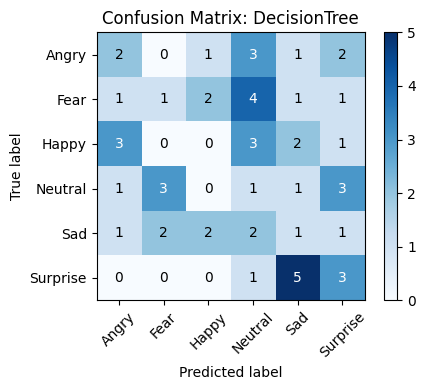

Training and evaluating model: SVM_RBF
Accuracy on JAFFE (SVM_RBF): 16.36%
Confusion matrix (rows = true, columns = predicted):
[[0 5 0 3 1 0]
 [0 1 5 1 1 2]
 [1 1 5 1 1 0]
 [0 5 3 0 0 1]
 [1 3 5 0 0 0]
 [0 6 0 0 0 3]]

Classification report:
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         9
        Fear       0.05      0.10      0.06        10
       Happy       0.28      0.56      0.37         9
     Neutral       0.00      0.00      0.00         9
         Sad       0.00      0.00      0.00         9
    Surprise       0.50      0.33      0.40         9

    accuracy                           0.16        55
   macro avg       0.14      0.16      0.14        55
weighted avg       0.14      0.16      0.14        55



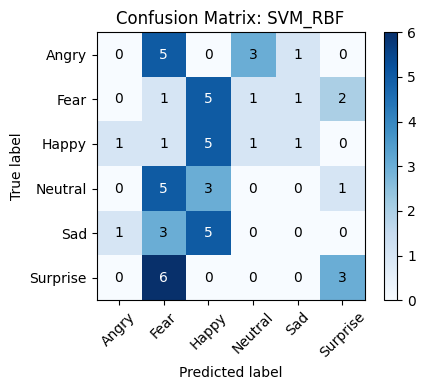

Training and evaluating model: KNN
Accuracy on JAFFE (KNN): 16.36%
Confusion matrix (rows = true, columns = predicted):
[[2 4 1 0 2 0]
 [2 1 3 0 2 2]
 [0 4 3 0 1 1]
 [2 2 2 0 2 1]
 [2 0 2 0 3 2]
 [2 3 1 1 2 0]]

Classification report:
              precision    recall  f1-score   support

       Angry       0.20      0.22      0.21         9
        Fear       0.07      0.10      0.08        10
       Happy       0.25      0.33      0.29         9
     Neutral       0.00      0.00      0.00         9
         Sad       0.25      0.33      0.29         9
    Surprise       0.00      0.00      0.00         9

    accuracy                           0.16        55
   macro avg       0.13      0.16      0.14        55
weighted avg       0.13      0.16      0.14        55



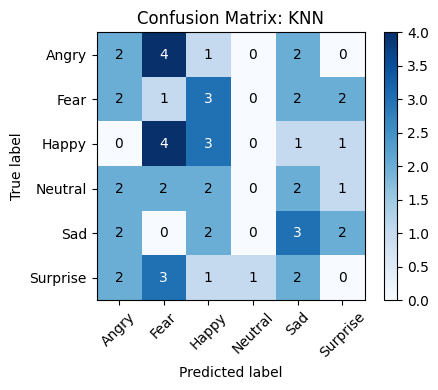

In [10]:
# Get a sorted list of class names (emotion labels) for consistent axis ordering
class_names = sorted(list(set(y_test)))   # Use test labels to define the class order

for name, model in models.items():
    print("Training and evaluating model:", name)

    # Train the model on the training features and labels
    model.fit(X_train_lbp, y_train)

    # Predict labels for the test set
    y_pred = model.predict(X_test_lbp)

    # Calculate overall accuracy on the test set
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy on JAFFE ({name}): {acc * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    print("Confusion matrix (rows = true, columns = predicted):")
    print(cm)

    # Print detailed classification report (precision, recall, F1-score)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, labels=class_names, zero_division=0))

    # Plot confusion matrix as an image
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.colorbar()

    # Set tick marks and labels for axes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add numbers to each cell in the confusion matrix
    for i in range(cm.shape[0]):          # Loop over rows (true classes)
        for j in range(cm.shape[1]):      # Loop over columns (predicted classes)
            cell_value = cm[i, j]
            # Choose text colour based on background intensity
            text_color = "white" if cell_value > cm.max() / 2.0 else "black"
            plt.text(j, i, cell_value, ha="center", va="center", color=text_color)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

Predicting Emotion for a Single JAFFE Image (Sample Output)

True Label: Happy


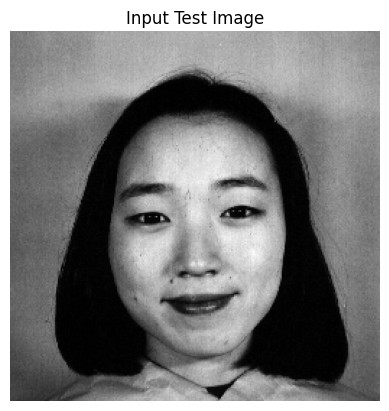

Model Predictions:
DecisionTree: Angry
SVM_RBF: Happy
KNN: Happy


In [11]:
# This gives sample outputs for the assignment report.
def predict_single_image(img, models_dict):

    # Resize image to 64x64 (same as training)
    img_resized = cv2.resize(img, (64, 64))

    # Compute its LBP histogram (same steps as in training)
    lbp = local_binary_pattern(img_resized, n_points, radius, method="uniform")
    hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, n_points + 3),
        range=(0, n_points + 2)
    )
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)

    # Reshape to 1 row so the model can take it
    feature_vector = hist.reshape(1, -1)

    # Show the image
    plt.imshow(img, cmap='gray')
    plt.title("Input Test Image")
    plt.axis('off')
    plt.show()

    # Print predictions from all models
    print("Model Predictions:")
    for name, model in models_dict.items():
        pred = model.predict(feature_vector)[0]
        print(f"{name}: {pred}")


# Pick a random test image to demonstrate
random_index = np.random.randint(0, len(X_test_imgs))
sample_img = X_test_imgs[random_index]

print("True Label:", y_test[random_index])
predict_single_image(sample_img, models)